In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc 
import tqdm

% matplotlib inline

In [2]:
# Obtain all labels
response = pd.read_csv('data/train_numeric.csv.zip', index_col=0, usecols=[0, 969])
df = pd.read_csv('data/train_date.csv.zip', index_col=0)
df = df.join(response)

C:\Users\home\Anaconda3\envs\kaggle\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
del response
gc.collect()

n_parts, n_columns = df.shape
n_columns -= 1
print(n_parts, n_columns)

1183747 1156


In [4]:
# stations and features in each station
stations = list(set([f.split('_')[1] for f in df.columns.tolist() if f!='Response']))

station_features = {s: [f for f in df.columns.tolist() if s in f] for s in stations }

In [5]:
# Calculate samples in each feature, if there is any station that every or almost every part flows by?
columns = df.columns.tolist()
feature_samples = {}
for col in tqdm.tqdm_notebook(columns):
    feature_samples[col] = len(df.loc[df[col].notna(), col])

feature_samples = pd.Series(feature_samples)
feature_samples.sort_values(ascending=False, inplace=True)
feature_samples.drop('Response', inplace=True)

In [6]:
s = {} # features that have the same number of samples
p = {} # stations having the same samples
for i, n in tqdm.tqdm_notebook(enumerate(feature_samples.unique())):
    s[i] = (n, feature_samples.loc[feature_samples==n].index.tolist())
    p[i] = (n, list(set([k.split('_')[1] for k in s[i][1]])))

### Start and end time on lines

In [7]:
line_features = {k: [c for c in columns if c.split('_')[0]==k] for k in ['L0', 'L1', 'L2', 'L3']}

In [8]:
N = 1000
line = {}

for l in line_features.keys():
    line[l+'_min'] = []
    line[l+'_max'] = []
    for i in tqdm.tqdm_notebook(range(n_parts//N+1)):
        tmp = df.iloc[i*N:min((i+1)*N, n_parts)].copy()
        line[l+'_min'].append(tmp[line_features[l]].min(axis=1))
        line[l+'_max'].append(tmp[line_features[l]].max(axis=1))
    line[l+'_min'] = pd.concat(line[l+'_min'])
    line[l+'_max'] = pd.concat(line[l+'_max'])
    
line = pd.DataFrame(line)

In [9]:
# Remove all features to save memory
for k in line_features.keys():
    df.drop(line_features[k], inplace=True, axis=1)

df = df.join(line)
df.reset_index(inplace=True)

### ID difference (+/- 1) when sorted by line start and end time 

In [10]:
def calc_stat(x, feat):
    a = x.groupby(feat).Response.agg(['mean', 'sum', 'count']).sort_values(['count'], ascending=False)
    a['confidence_interval'] = 1.96 * np.sqrt(a['mean'] * (1-a['mean']) / a['count'])
    a['mean_low'] = a['mean'] - a['confidence_interval']
    a['mean_high'] = a['mean'] + a['confidence_interval']
    a.sort_values('count', ascending=False, inplace=True)
    return a

In [11]:
a = calc_stat(df, 'L0_min')

In [12]:
cols = df.columns[2:]
x = df.copy()
stat = {}
for c in tqdm.tqdm_notebook(cols):
    l = c.split('_')[0]
    df.sort_values([c, 'Id'], ascending=True, inplace=True)
    x[c+'_diff1'] = df.Id.diff().fillna(9999999).astype(int)
    x[c+'_diff2'] = df.Id.diff(-1).fillna(9999999).astype(int)
    stat[c+'_diff1'] = calc_stat(x, c+'_diff1')
    stat[c+'_diff2'] = calc_stat(x, c+'_diff1')

In [13]:
key_list = list(stat.keys())
y_bar = [stat[k].iloc[0]['mean'] for k in key_list]
y_err = [stat[k].iloc[0]['confidence_interval'] for k in key_list]

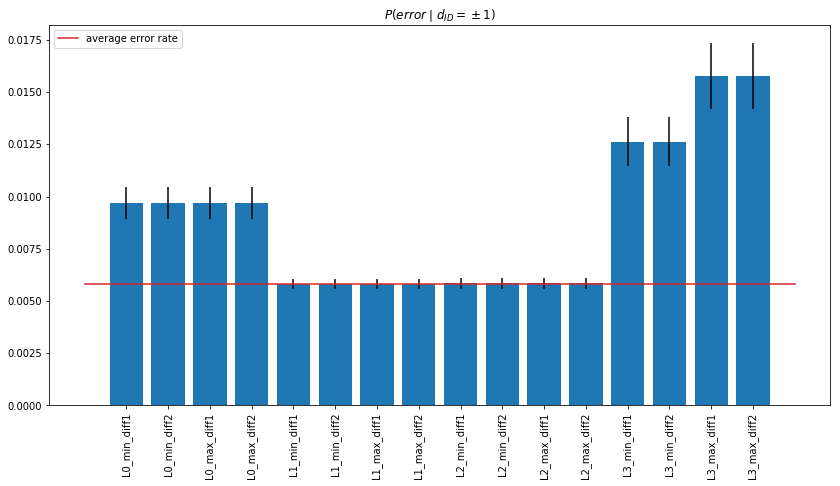

In [14]:
plt.figure(figsize=(14, 7))
plt.bar(np.arange(len(key_list)), y_bar, yerr=y_err)
plt.xticks(np.arange(len(key_list)), key_list, rotation='vertical')
plt.plot([-1, 16], [0.0058, 0.0058], color='tab:red', label='average error rate')
plt.legend(loc='upper left')
plt.title('$P(error \mid d_{ID}=\pm 1)$')
plt.show()

L0 and L3 may be helpful in finding errors.

### The start and end time on lines categorized by quantiles
The start and end time are similar, only one needs to be kept

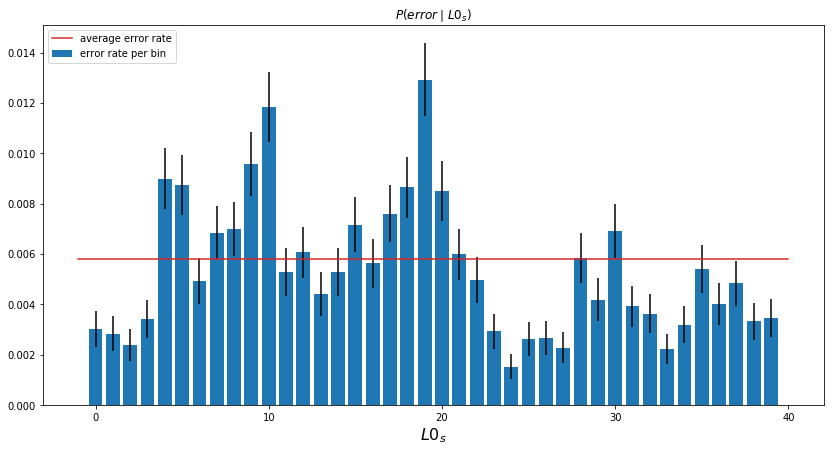

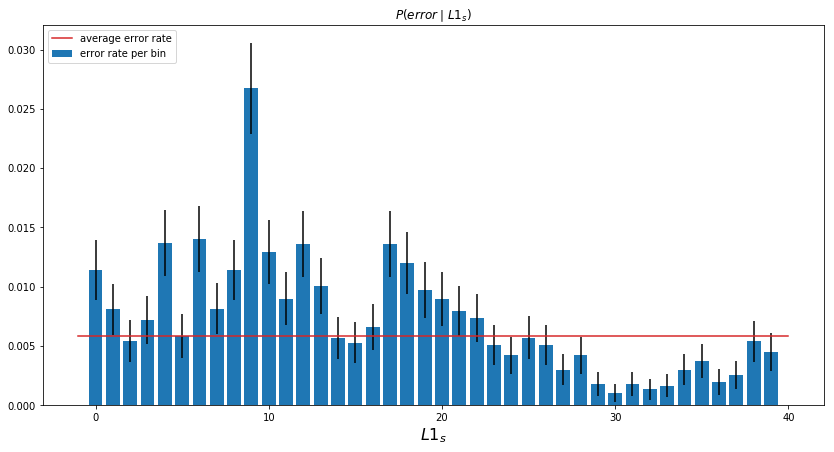

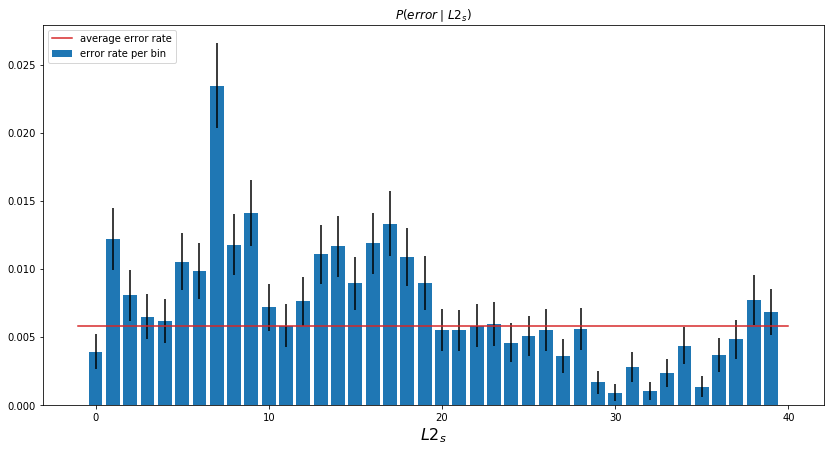

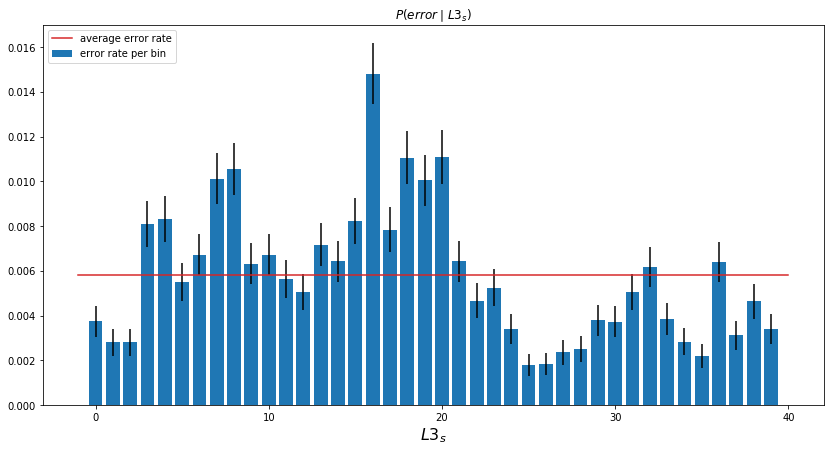

In [106]:
for i in range(4):
    bins = 40
    x['L{}_min_cat'.format(i)] = pd.qcut(x['L{}_min'.format(i)], bins, labels=False)

    a = x.groupby('L{}_min_cat'.format(i)).Response.agg(['mean', 'sum', 'count']).sort_values('mean', ascending=False)
    a['confidence_interval'] = 1.96 * np.sqrt(a['mean'] * (1-a['mean']) / a['count'])
    a['mean_low'] = a['mean'] - a['confidence_interval']
    a['mean_high'] = a['mean'] + a['confidence_interval']

    plt.figure(figsize=(14, 7))
    plt.bar(a.index, a['mean'], yerr=a['confidence_interval'], label='error rate per bin')
    # plt.xticks(np.arange(len(key_list)), key_list, rotation='vertical')
    plt.plot([-1, bins], [0.0058, 0.0058], color='tab:red', label='average error rate')
    plt.legend(loc='upper left')
    plt.title('$P(error \mid L{}_s)$'.format(i))
    plt.xlabel('$L{}_s$'.format(i), fontsize=16)
    plt.show()

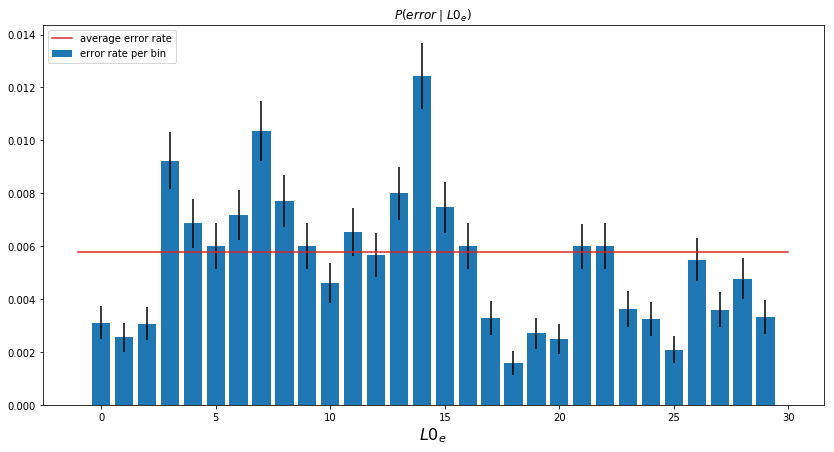

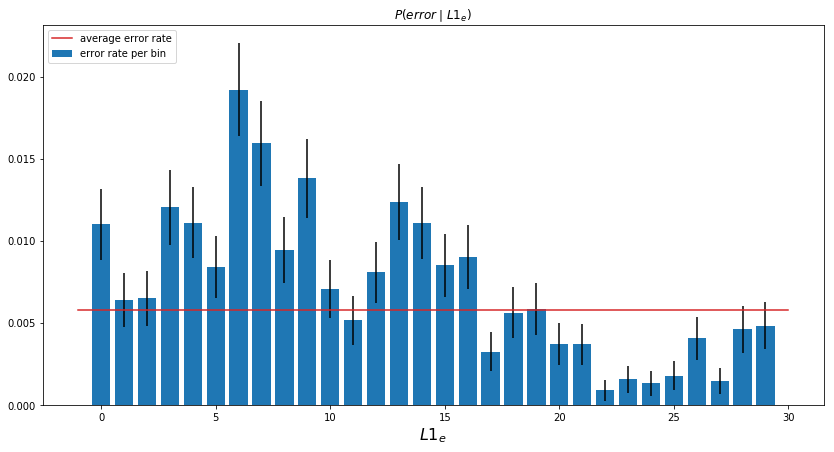

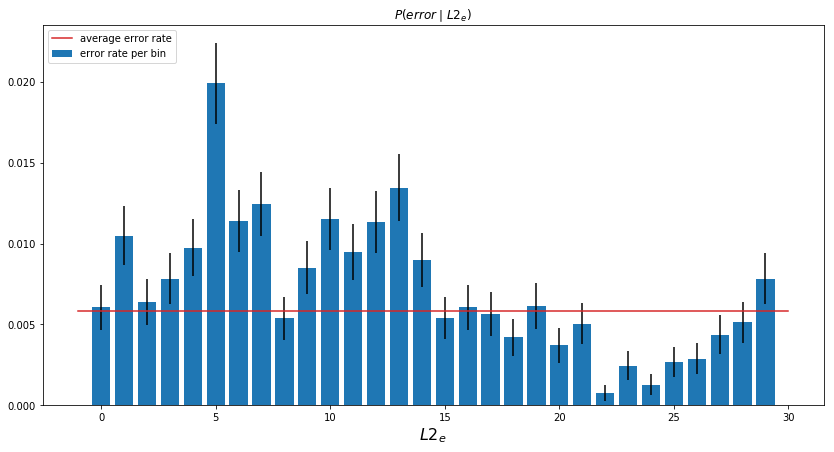

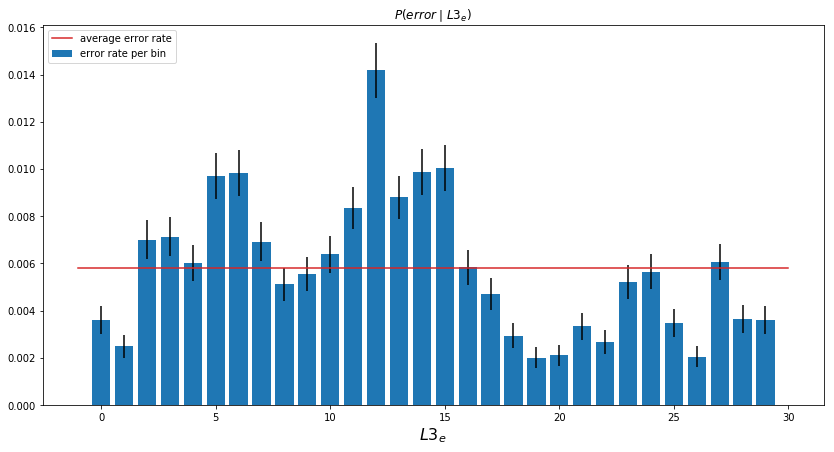

In [74]:
for i in range(4):
    bins = 40
    x['L{}_max_cat'.format(i)] = pd.qcut(x['L{}_max'.format(i)], bins, labels=False)

    a = x.groupby('L{}_max_cat'.format(i)).Response.agg(['mean', 'sum', 'count']).sort_values('mean', ascending=False)
    a['confidence_interval'] = 1.96 * np.sqrt(a['mean'] * (1-a['mean']) / a['count'])
    a['mean_low'] = a['mean'] - a['confidence_interval']
    a['mean_high'] = a['mean'] + a['confidence_interval']

    plt.figure(figsize=(14, 7))
    plt.bar(a.index, a['mean'], yerr=a['confidence_interval'], label='error rate per bin')
    # plt.xticks(np.arange(len(key_list)), key_list, rotation='vertical')
    plt.plot([-1, bins], [0.0058, 0.0058], color='tab:red', label='average error rate')
    plt.legend(loc='upper left')
    plt.title('$P(error \mid L{}_e)$'.format(i))
    plt.xlabel('$L{}_e$'.format(i), fontsize=16)
    plt.show()

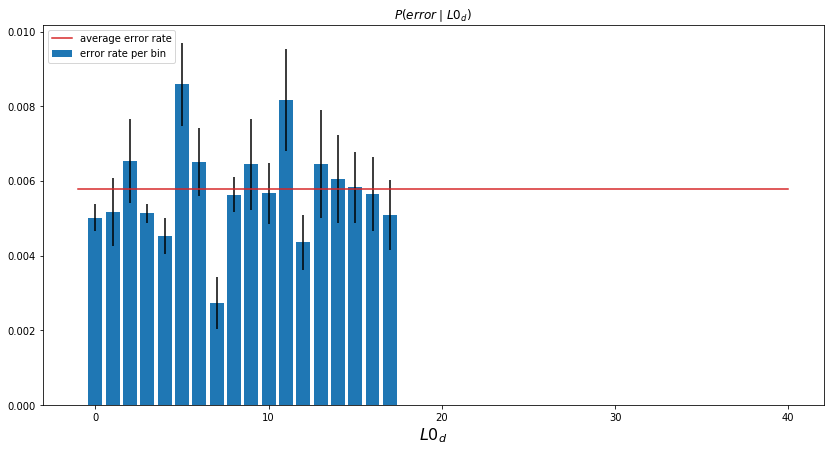

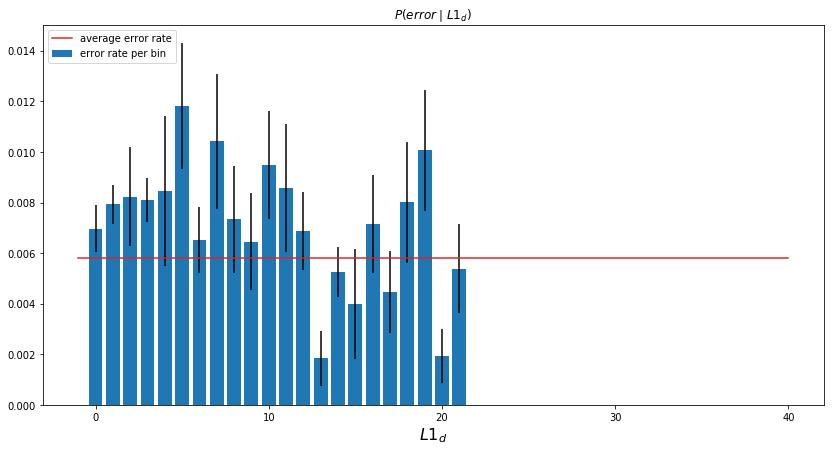

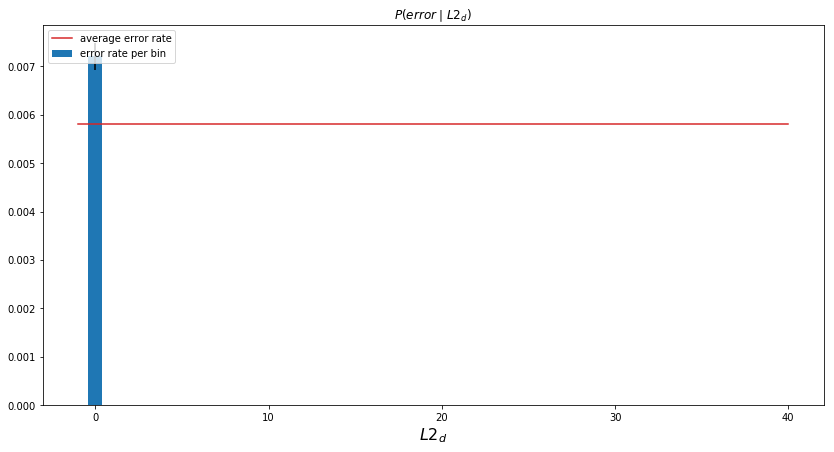

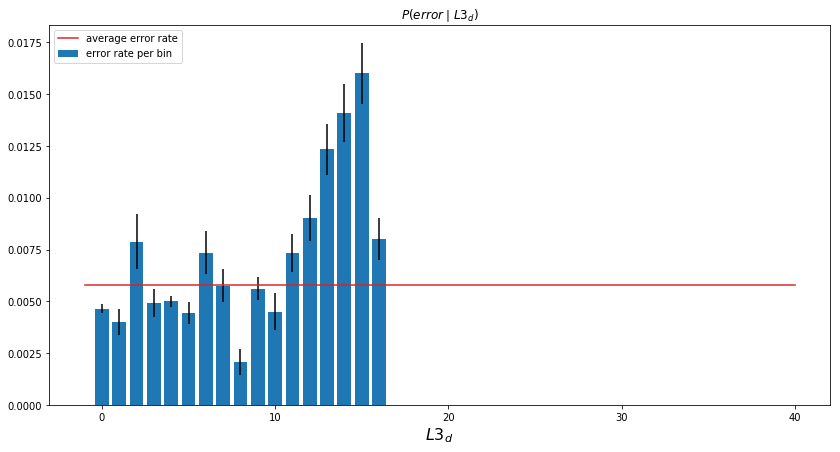

In [105]:
for i in range(4):
    bins = 40
    x['L{}_duration'.format(i)] = x['L{}_max'.format(i)] - x['L{}_min'.format(i)]
    x['L{}_duration_cat'.format(i)] = pd.qcut(x['L{}_duration'.format(i)], bins, labels=False, duplicates='drop')

    a = x.groupby('L{}_duration_cat'.format(i)).Response.agg(['mean', 'sum', 'count']).sort_values('mean', ascending=False)
    a['confidence_interval'] = 1.96 * np.sqrt(a['mean'] * (1-a['mean']) / a['count'])
    a['mean_low'] = a['mean'] - a['confidence_interval']
    a['mean_high'] = a['mean'] + a['confidence_interval']

    plt.figure(figsize=(14, 7))
    plt.bar(a.index, a['mean'], yerr=a['confidence_interval'], label='error rate per bin')
    # plt.xticks(np.arange(len(key_list)), key_list, rotation='vertical')
    plt.plot([-1, bins], [0.0058, 0.0058], color='tab:red', label='average error rate')
    plt.legend(loc='upper left')
    plt.title('$P(error \mid L{}_d)$'.format(i))
    plt.xlabel('$L{}_d$'.format(i), fontsize=16)
    plt.show()

In [107]:
x.columns

Index(['Id', 'Response', 'L0_min', 'L0_max', 'L1_min', 'L1_max', 'L2_min',
       'L2_max', 'L3_min', 'L3_max', 'L0_min_diff1', 'L0_min_diff2',
       'L0_max_diff1', 'L0_max_diff2', 'L3_min_diff1', 'L3_min_diff2',
       'L3_max_diff1', 'L3_max_diff2', 'L0_min_cat', 'L0_max_cat',
       'L1_min_cat', 'L2_min_cat', 'L3_min_cat', 'L1_max_cat', 'L2_max_cat',
       'L3_max_cat', 'L0_duration', 'L0_duration_cat', 'L1_duration_cat',
       'L2_duration_cat', 'L3_duration_cat', 'L1_duration', 'L2_duration',
       'L3_duration'],
      dtype='object')

In [108]:
x.sort_values('Id', inplace=True)
x.to_csv('train_line_time.csv', index_label='Id', index=False)